In [1]:
import awkward as ak
import os
import keras
import numpy as np
import uproot
import nbimporter
import import_ipynb
import matplotlib.pyplot as plt
from hffrag import fixedbinning
from hffrag import binneddensity
from numpy.lib.recfunctions import structured_to_unstructured
import tensorflow as tf
import DeepSetNeuralNet2


2022-11-17 20:12:37.783780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 20:12:37.937207: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-17 20:12:37.942925: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 20:12:37.942937: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo


PDG ID: 531
number of b-hadrons: 13487

PDG ID: -521
number of b-hadrons: 61531

PDG ID: -511
number of b-hadrons: 61243

PDG ID: 5232
number of b-hadrons: 751

PDG ID: 511
number of b-hadrons: 61706

PDG ID: 521
number of b-hadrons: 61594

PDG ID: -531
number of b-hadrons: 13526

PDG ID: -5122
number of b-hadrons: 5447

PDG ID: 5122
number of b-hadrons: 5232

PDG ID: -5132
number of b-hadrons: 676

PDG ID: 5132
number of b-hadrons: 722

PDG ID: -5232
number of b-hadrons: 733

PDG ID: 555
number of b-hadrons: 3

PDG ID: 553
number of b-hadrons: 6

PDG ID: -5332
number of b-hadrons: 21

PDG ID: 5332
number of b-hadrons: 18

PDG ID: 100553
number of b-hadrons: 1

PDG ID: -541
number of b-hadrons: 5

PDG ID: 10551
number of b-hadrons: 3

PDG ID: 541
number of b-hadrons: 5

PDG ID: 20553
number of b-hadrons: 1



In [2]:
%matplotlib inline 

In [1]:
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPoints/DeepNetWeights&Biases-{epoch:04d}.ckpt"
checkpoint = os.path.dirname(path)
latest_DeepNet = tf.train.latest_checkpoint(checkpoint)


NameError: name 'tf' is not defined

In [4]:
#The data is being stored in a tree datastructure. 
#We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")

In [5]:
MAXEVENTS = 1e20
MAXTRACKS = 8
LR = 1e-3

In [6]:
#Read in the data from the root file
track_features = ["AnalysisTracks_pt","AnalysisTracks_eta","AnalysisTracks_phi","AnalysisTracks_z0sinTheta","AnalysisTracks_d0sig","AnalysisTracks_d0","AnalysisTracks_d0sigPV","AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi"]
features = tree.arrays(jet_features+track_features,entry_stop = MAXEVENTS)

In [7]:
#Select the events of interest
events = features[ak.sum(features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis = 1) > 0]

In [10]:
#Displays the number of jets being trained on
jets = events[jet_features][:,0]
print("The number of jets to train on is: ", len(jets))

#Select tracks from the events
tracks = events[track_features]

#Match the tracks to the jets
matchedtracks = tracks[DeepSetNeuralNet2.Match_Tracks(jets,tracks)]

#Pad and Flatten the data
matchedtracks = DeepSetNeuralNet2.flatten(matchedtracks, MAXTRACKS)

# Identify the the bottom jets and their associated tracks
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads = np.stack([bhads_pt,bhads_eta,bhads_phi],axis = -1)

print("There are {} outputs".format(np.shape(bhads)[1]))
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1]))

#Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-3]])
matchedtracks = structured_to_unstructured(matchedtracks)

#Fix the angles
jets = DeepSetNeuralNet2.pt_eta_phi_2_px_py_pz_jets(jets).to_numpy()
tracks_p = DeepSetNeuralNet2.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DeepSetNeuralNet2.pt_eta_phi_2_px_py_pz_jets(bhads)
print(np.shape(tracks_p))
print(np.shape(matchedtracks[:, :, 3:]))
tracks = np.concatenate([tracks_p,matchedtracks[:,:,3:].to_numpy()],axis = 2)

The number of jets to train on is:  141329
There are 3 outputs
There are 8 inputs
(68143, 8, 3)
(68143, 8, 5)


DeepSetNeuralNet2.ipynb:16: RuntimeWarning: overflow encountered in sinh
  "2022-11-17 20:10:45.740874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory\n",


In [11]:
#Builds the deep neural network
track_layers = [192, 192, 192, 192, 192]
jet_layers = [192, 192, 192, 192, 192]
DeepNet = DeepSetNeuralNet2.DeepSetNeuralNetwork(
    [len(track_features)]+track_layers, jet_layers,3,LR)
DeepNet.summary()

2022-11-17 20:16:41.934079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-17 20:16:41.934110: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-17 20:16:41.934127: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2022-11-17 20:16:41.934348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 8)]         0         
                                                                 
 masking (Masking)           (None, None, 8)           0         
                                                                 
 time_distributed (TimeDistr  (None, None, 8)          72        
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, None, 8)          32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, None, 192)        1728      
 tributed)                                                       
                                                             

In [20]:
DeepNet.load_weights(latest_DeepNet)
#Specify the neural network's optimizer and loss function
#loss = DeepNet.evaluate(tracks,bhads,verbose = 2)
#print("The Loaded DeepNet has loss: ", round(loss,3))

In [19]:
predictions = DeepNet.predict(tracks)

2130/2130 [==============================] - 4s 2ms/step


In [21]:
print(predictions[:10])
print(bhads[:10])

[[-2.753358  10.708667   0.5900288 10.552632  11.296181  11.850632 ]
 [-6.408173   6.6502466  6.684803  11.434992  10.848004  12.589287 ]
 [-3.960971   5.438645  -6.3400564 10.509065  10.540565  11.780427 ]
 [-2.9060004  6.224935  -3.0575204 10.636841  11.040161  12.105967 ]
 [-3.5976918  4.6981325 -4.307052  10.755831  10.755084  11.905343 ]
 [-1.9347639 10.334334  -0.9760309 10.434327  11.340539  11.648817 ]
 [-5.6745014  6.0336013 -1.4753944 11.018805  10.696506  12.124299 ]
 [-4.9063144  4.560541  -6.0045066 10.829867  10.613258  11.6958275]
 [-1.534041   6.467326  -2.8918898 10.383609  10.712783  11.7952795]
 [-5.353084   9.423264   1.0888112 10.258988  11.059976  11.009123 ]]
[[  48855.56531144  128363.19160447  124938.01790683]
 [    843.45625286   77133.74792279  179693.16123271]
 [ -77645.8243511   -61246.03310984 -543946.69198392]
 [  14105.86372119  -28270.27862345    3567.73767912]
 [  19637.04494914  -28563.57486597  -26376.60331503]
 [ -30646.74970554   73222.93169604  -3

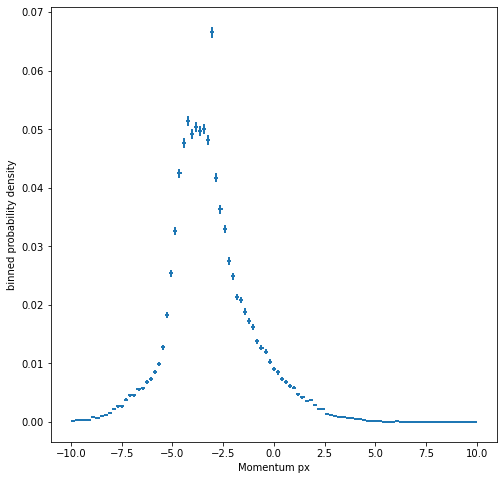

In [34]:
DeepSetNeuralNet2.binneddensity(predictions[:,0],DeepSetNeuralNet2.fixedbinning(-10,10,100),xlabel = "Momentum px")

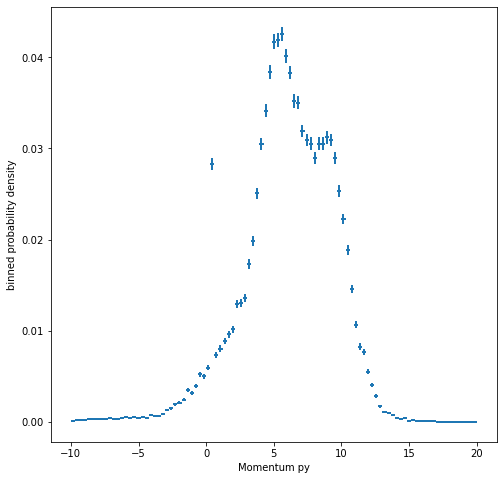

In [35]:
DeepSetNeuralNet2.binneddensity(predictions[:,1],DeepSetNeuralNet2.fixedbinning(-10,20,100),xlabel = "Momentum py")

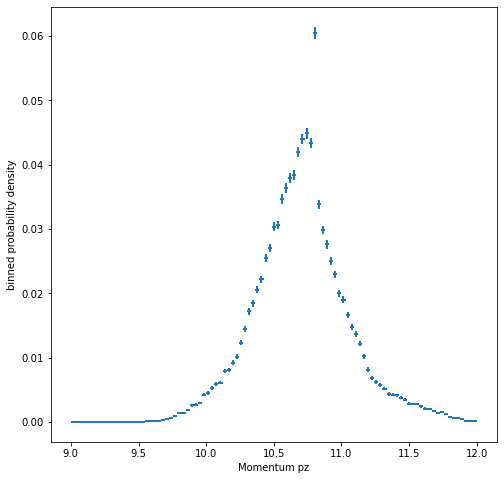

In [36]:
DeepSetNeuralNet2.binneddensity(predictions[:,3],DeepSetNeuralNet2.fixedbinning(9,12,100),xlabel = "Momentum pz")